# Attempt to reproduce Parrish et al. 2020 Bathy results

#### Try to reproduce top panel Fig 12 from "Validation of ICESat-2 ATLAS Bathymetry and Analysis of ATLAS’s Bathymetric Mapping Performance" in Remote Sensing MDPI

In [1]:
import geopandas as gpd
import h5py
import importlib
import json
import lxml
import math
import matplotlib
import numpy as np
import os
import pandas as pd
import pyproj as proj
import rasterio
import requests
import seaborn as sns
import sys
import zipfile
import fiona

from bs4 import BeautifulSoup
from datetime import datetime
from pathlib import Path
from scipy.stats import pearsonr
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from sklearn.cluster import DBSCAN
from shapely.geometry import Point
from tqdm import tqdm

import ATL03_API as is2api
import Coral_Reef as coral_reef
import Depth_profile as depth
import ICESAT_plots as is2_plot
import IS2_file as is2File
import Pixel_transformation as pt
import Reef_plots as reef_plots
import Sentinel_API as sentinel
import Sentinel2_image as s2_img
import Tide_API as tide
import Water_level as water_level

#!! additional packages I added
import datetime
import pytz
from astropy.time import Time
from astral import LocationInfo
from astral.sun import sun
import matplotlib.pyplot as plt
from pyproj import CRS
from pyproj import Transformer
import scipy.spatial as spatial
from sklearn.neighbors import NearestNeighbors



In [2]:
# set up definitions of pathnames and coordinates

reef_name = 'St_Thomas_USVI'

# define path names
base_dir = '/Users/bonnieludka/Spaceship/IceSAT2/bathymetry_python_20210113'
data_dir = os.path.join(base_dir,'data')
reef_path = os.path.join(data_dir,reef_name)
h5_dir = os.path.join(reef_path,'H5')
outfile_path = os.path.join(reef_path,'Output')
data_cleaning_path = os.path.join(outfile_path,'Data_Cleaning')
icesat_fp = os.path.join(data_cleaning_path,'ICESAT_photons')

# setup coordinate projections
crs_wgs = CRS(4326) # WGS84 geographic
crs_bng = CRS(3857) # CRS with units of meters

# get reef bounding box coords
# # loads in geojson of reef into geopandas
# geojson_fp = os.path.join(reef_path,reef_name + '.geojson')
# reef_gjson = gpd.read_file(geojson_fp)
# reef_polygon = reef_gjson.geometry[0]
# # get min_lon,min_lat,max_lon,max_lat bounds
# coords = reef_polygon.bounds
# min_longitude,min_latitude,max_longitude,max_latitude = coords
min_longitude = -65.099772
max_longitude = -64.80988000001545
min_latitude = 18.266479
max_latitude = 18.35231499999874

# get data file names
h5_filenames = [f for f in os.listdir(h5_dir) if not f.startswith('.')]

In [3]:
# x-y rotation function used to convert to along-track coordinate frame
def xyRotate(x,y,theta,**kwargs):
    """
    xyRotate  Rotate data.
    clockwise rotation around origin XO,YO
    [XR YR] = xyRotate(X,Y,THETA) rotates the coordinates X,Y by THETA
    (theta in radians). (Origin does not move, X0 = 0, Y0 = 0)
    OR
    [XR YR] = xyRotate(X,Y,THETA,xo=XO,yo=YO) rotates the coordinates around the
    origin XO,YO.
    Note: Clunky as this is modified from one of my Matlab functions. Find more 'pythonic' way?
    """
    # Default origin is 0,0
    xo = kwargs.get("xo",0)
    yo = kwargs.get("yo",0)
    # Ravel and Translate
    xt = np.ravel(x)-xo
    yt = np.ravel(y)-yo
    # Create xy Matrix of raveled translated data
    xt = xt.reshape(len(xt),1)
    yt = yt.reshape(len(yt),1)
    XYt = np.hstack((xt,yt))
    # Rotation Matrix
    R = np.array([[np.cos(theta), np.sin(theta)],
                  [-np.sin(theta),  np.cos(theta)]])
    # Rotate
    XYr = np.matmul(XYt,R)
    xrlong = XYr[:,0]
    yrlong = XYr[:,1]
    xr = xrlong.reshape(x.shape)
    yr = yrlong.reshape(y.shape)
    return xr, yr

### Get ICESat-2 data

In [4]:
# only 1 h5 file for now. When more files are downloaded will need to create a loop here
h5_fn = h5_filenames[0]
print(h5_fn)

# load in h5 file 
h5 = h5py.File(os.path.join(h5_dir,h5_fn),'r')

# define strong laser indexing based on sc orientation
sc_orient = h5['orbit_info']['sc_orient'][...][0]
if sc_orient == 1:
    strong_beams = ['gt1r', 'gt2r', 'gt3r']
else:
    strong_beams = ['gt1l', 'gt2l', 'gt3l']
# reference GPS time
[tref] = h5.get('ancillary_data/atlas_sdp_gps_epoch')

processed_ATL03_20181118180604_07810101_003_01.h5


In [5]:
laser = 'gt3r'

# Output directory for csv file containing raw photon data
photon_fn = '{reef_name}_photons_{h5_fn}_{laser}.csv'.format(reef_name=reef_name, h5_fn=h5_fn.split('.')[0], laser=laser)
photons_path = os.path.join(icesat_fp, photon_fn)
print(photons_path)

if not os.path.exists(photons_path):

    # load in photon data
    if laser + '/heights/' in h5.keys():
        height = h5.get(laser + '/heights/h_ph')
        lat = h5.get(laser + '/heights/lat_ph')
        lon = h5.get(laser + '/heights/lon_ph')
        conf = h5.get(laser + '/heights/signal_conf_ph')
        confidence = np.array(conf)
        conf_land = confidence[:,0]
        conf_ocean = confidence[:,1]
        conf_inlandwater = confidence[:,3]
        # !!! Added a time column
        dtime = h5.get(laser + '/heights/delta_time') 
        photon_data = [height,lat,lon,conf_land,conf_ocean,conf_inlandwater,dtime]
    else:
        photon_data = []

    if len(photon_data) == 0:
        print('No photons in file for {}'.format(laser))
        
    # create dataframe of photon data
    df_laser = pd.DataFrame(photon_data).T
    df_laser.columns = ['Height','Latitude','Longitude','Conf_land','Conf_ocean','Conf_inlandwater','dtime']

    # Clip dataframe to locations within the reef bounding box
    df = pd.DataFrame()
    df = df_laser.loc[(df_laser.Longitude > min_longitude) & (df_laser.Longitude < max_longitude) &\
    (df_laser.Latitude > min_latitude) & (df_laser.Latitude < max_latitude)]
    df.is_copy = None

    #If there are photons in the new clipped dataframe
    if len(df) != 0:  

        # !!! Saving clipped photons in original vertical datum
        # !!! This is different from Sunil-Borsa code, which saves in vert. coord. relative to estimated sea surface

        # !!! also adding x and y coords in the same dataframe

        transformer = Transformer.from_crs(crs_wgs, crs_bng,always_xy=True)
        df.loc[:,'x'],df.loc[:,'y'] =  transformer.transform(df.Longitude.values, df.Latitude.values)

        # !!! also adding track-oriented coordinates

        # fit a line to the data
        m, b = np.polyfit(df.x.values, df.y.values, 1)
        # calculate rotation and translation parameters from fit for new track-oriented coords 
        # rotation angle
        theta = -np.arctan(-(1/m))
        # offset such that southernmost point is zero
        y0 = min(df.y.values)
        x0 = (y0-b)/m
        # translate and rotate to along (alg) and cross (crs) track coordinates
        df.loc[:,'crs'], df.loc[:,'alg'] = xyRotate(df.x.values,df.y.values,theta,xo=x0,yo=y0)

        print('Writing photons for clipped dataframe to csv file for {}'.format(laser))
        df.to_csv(photons_path)

    else:
        print('No photons over reef for {}'.format(laser))
        df.to_csv(photons_path)
else:
    print('\n' + 'Reading photons from prior csv file for {}'.format(laser))
    df = pd.read_csv(photons_path)
    metadata_path = os.path.join(reef_path, 'ICESAT_metadata.json')
    if os.path.exists(metadata_path):
        metadata = json.load(open(metadata_path))

print(df)

/Users/bonnieludka/Spaceship/IceSAT2/bathymetry_python_20210113/data/St_Thomas_USVI/Output/Data_Cleaning/ICESAT_photons/St_Thomas_USVI_photons_processed_ATL03_20181118180604_07810101_003_01_gt3r.csv

Reading photons from prior csv file for gt3r
       Unnamed: 0  Height_raw   Latitude  Longitude  Conf_land  Conf_ocean  \
0               0   94.935738  18.266519 -64.988895        0.0         0.0   
1               1  -43.994507  18.266514 -64.988863        4.0         3.0   
2               2  -44.256413  18.266514 -64.988863        4.0         4.0   
3               3  -88.141914  18.266519 -64.988854        0.0         0.0   
4               4 -194.532059  18.266515 -64.988830        0.0         0.0   
...           ...         ...        ...        ...        ...         ...   
51529       51529 -171.045685  18.352300 -64.997692        0.0         0.0   
51530       51532  -27.926647  18.352312 -64.997726        2.0         2.0   
51531       51533  -31.290192  18.352312 -64.997725  

In [6]:
# plot data where confidence is different size / color marker

# Land Confidence
plt.figure(figsize=(16,6))
sct_land = plt.scatter(df.Latitude, df.Height, s = (df.Conf_land+2)*5, c = df.Conf_land)
cbar = plt.colorbar(sct_land)
cbar.set_label('Land Confidence',fontsize=14)
plt.grid(True)
plt.xlabel('Latitude', fontsize=16)
plt.ylabel('Height (m)', fontsize=16)
plt.xlim(min(df.Latitude), max(df.Latitude))
plt.ylim(-100, 0)
#plt.title(pf, fontsize=16)
# Ocean Confidence
plt.figure(figsize=(16,6))
sct_oc = plt.scatter(df.Latitude, df.Height, s = (df.Conf_ocean+2)*5, c = df.Conf_ocean)
cbar = plt.colorbar(sct_oc)
cbar.set_label('Ocean Confidence',fontsize=14)
plt.grid(True)
plt.xlabel('Latitude', fontsize=16)
plt.ylabel('Height (m)', fontsize=16)
plt.xlim(min(df.Latitude), max(df.Latitude))
plt.ylim(-100, 0)
#plt.title(pf, fontsize=16)

AttributeError: 'DataFrame' object has no attribute 'Height'

<Figure size 1152x432 with 0 Axes>

(51534,)
(51534,)
(51534,)
(4704, 2)
(4704,)


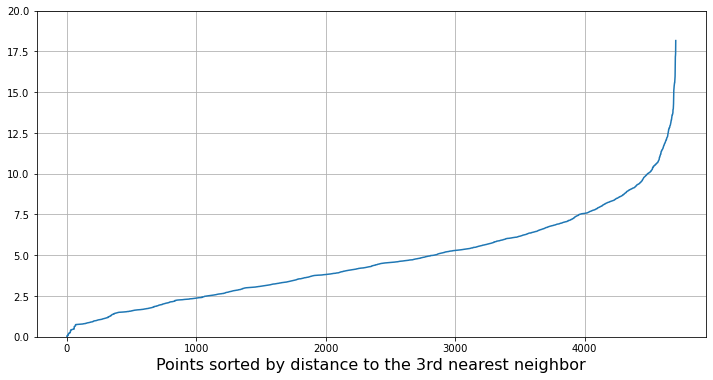

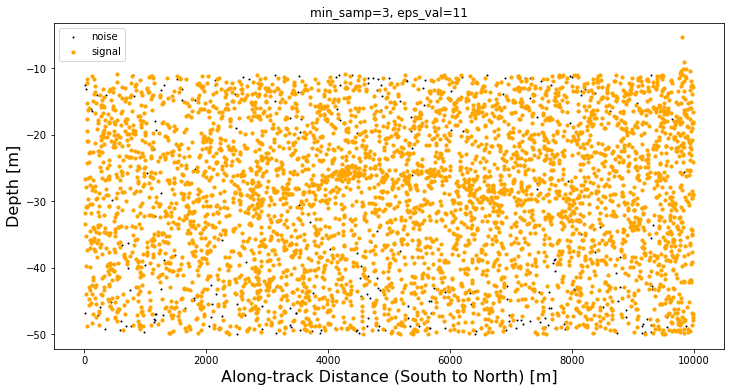

In [10]:
if len(df) != 0: 
    
    # find sea surface using confidence level 4 ocean photons
    df_ss = df.loc[df.Conf_ocean == 4]
    
    if len(df_ss) != 0:
    
        # extract photons associated with ocean surface
        water_thresh_high = 1.25
        water_thresh_low = -1.25
        surface = df_ss.loc[(df_ss.Height_raw > df_ss.Height_raw.median() + water_thresh_low) & (df_ss.Height_raw < df_ss.Height_raw.median() + water_thresh_high)]

        # creating a df with just the latitude and height
        sea_level = pd.DataFrame([surface.Height_raw, surface.alg]).T.dropna()
        sea_level.columns = ['water','alg']

        # fitting line to remaining points
        ss = np.polyfit(sea_level.alg, sea_level.water,1)
        f = np.poly1d(ss)
        # getting absolute error for each point
        sea_level['abs_diff'] = np.abs(sea_level.water - f(sea_level.alg))
        # retaining only points with absolute error less than 2
        sea_level = sea_level.loc[sea_level.abs_diff < 2]

        # fitting a parabolic function to the remaining points
        ss2 = np.polyfit(sea_level.alg, sea_level.water,2)
        f2 = np.poly1d(ss2)
        # getting absolute error for each point
        sea_level['abs_diff'] = np.abs(sea_level.water - f2(sea_level.alg))
        # retaining only points with absolute error less than 1
        sea_level = sea_level.loc[sea_level.abs_diff < 1]

        # fitting a parabolic function to the remaining points
        z3 = np.polyfit(sea_level.alg, sea_level.water,2)
        f3 = np.poly1d(z3)

        # adjust photons to sea level
        sea = np.array(f3(df.alg))
        h = df.Height_raw.values-sea
        
        # adjust depth for speed of light in water
        speed_of_light_air = 299710		#assumes 532 nm wavelength, ir = 1.000273027 (https://emtoolbox.nist.gov/wavelength/ciddor.asp)
        speed_of_light_water = 218826	#assumes 532 nm wavelength, index of refraction in water of 1.37 (Mangano et al., 2013)
        coef = speed_of_light_water / speed_of_light_air
        h = h * coef
        
        
        alg = df.alg.values
        confo = df.Conf_ocean.values
        
        # just look at section of water column of interest
        b_low = -50
        b_hi = -1
        print(confo.shape)
        print(alg.shape)
        print(h.shape)
        algs = alg[(h < b_hi) & (h>b_low)]
        confos = confo[(h < b_hi) & (h>b_low)]
        hs = h[(h < b_hi) & (h>b_low)]
        
        # just look at section of track of interest
        b_left = 0
        b_right = 10000
        hs = hs[(algs >b_left) & (algs<b_right)]
        confos = confos[(algs >b_left) & (algs<b_right)]
        algs = algs[(algs >b_left) & (algs<b_right)]
    
        
        # just use confidence levels that look like they have bathy
        hs = hs[confos==0]
        algs = algs[confos==0]
        
        
        # Classify seafloor photons
        algs = algs.reshape(len(algs),1)
        hs = hs.reshape(len(hs),1)
        ha = np.hstack((hs,algs))
        print(ha.shape)
        #ah = np.hstack((algs,hs))
        # https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
        min_samp = 3#2
        neighbors = NearestNeighbors(n_neighbors=min_samp)
        neighbors_fit = neighbors.fit(ha)
        distances, indices = neighbors_fit.kneighbors(ha)
        distances = np.sort(distances, axis=0)
        distances = distances[:,1]
        plt.figure(figsize=(12,6))
        plt.plot(distances)
        #plt.xlim((0,500))
        plt.ylim(0,20)
        plt.grid(True)
        plt.xlabel("Points sorted by distance to the "+ str(min_samp) + "rd nearest neighbor", fontsize=16)
        
        
        eps_val = 11#6
        
        dbscan = DBSCAN(eps = eps_val, min_samples = min_samp)
        
        if len(ha) != 0:
            model = dbscan.fit(ha)
            labels = model.labels_
            print(labels.shape)
            #signal
            a_sig = algs[labels >= 0]
            h_sig = hs[labels >= 0]
            #noise
            a_ns = algs[labels < 0]
            h_ns = hs[labels < 0]
        else:
            a_sig = pd.DataFrame()
            h_sig = pd.DataFrame()
            a_ns = pd.DataFrame()
            h_ns = pd.DataFrame()
            
        plt.figure(figsize=(12,6))
        plt.scatter(a_ns, h_ns, s = 1, color = 'black', label = 'noise')
        plt.scatter(a_sig,h_sig, s= 10, color = 'orange',label = 'signal') 
        plt.legend
        plt.title('min_samp='+ str(min_samp) + ', eps_val=' + str(eps_val))
        plt.xlabel('Along-track Distance (South to North) [m]', fontsize=16)
        plt.ylabel('Depth [m]', fontsize=16)
        plt.legend()
        
            

### Get ground truth data

My download parameters using NOAA Digital Coast:
2014 USGS EAARL Topobathy Lidar: USVI (Job601850_2014_eaarlb_usvi)
Projection: Geographic (Lat/Lon)
Zone: N/A
Horizontal Datum: WGS84/ITRF
Horizontal Units: Decimal Degrees
Vertical Datum: WGS84/ITRF94 Ellipsoid
Vertical Units: Meters
File Format: ASCII Grid
Bin Method: Average, Bin Size: 2.0m
Bin Units: Meters
Data Classification: All Points
Data Returns: Any Points
Ancillary Data: No Ancillary Data

In [7]:
# load depth data matrix
fpath = os.path.join(reef_path,'Ground_truth','USGS_EAARL_2014_med_10mRes','USGS_EAARL_2014_med_10mRes.asc')
zmflipped = np.loadtxt(fpath, skiprows=6)
zm = np.flipud(zmflipped)
data_info= np.loadtxt(fpath, dtype = 'str',max_rows=6)
ncols = int(data_info[0,1])
nrows = int(data_info[1,1])
xllcorner = float(data_info[2,1])
yllcorner = float(data_info[3,1])
cellsize = float(data_info[4,1])
NODATA_value = float(data_info[5,1]) #does it matter if this is an int or float?

print(zm.shape)

NX    = ncols-1
NY    = nrows-1
lon1  = xllcorner
lat1  = yllcorner
delta = cellsize   

# Create longitude and latitude coords
lonc   = np.arange(lon1,delta*NX+lon1+delta/2,delta) 
latc   = np.arange(lat1,delta*NY+lat1+delta/2,delta)
print(lonc.shape)
print(latc.shape)

# create lat and lon matrix that matches z elevation matrix
lonm, latm = np.meshgrid(lonc, latc, sparse=False, indexing='xy')
print(lonm.shape)
print(latm.shape)

# unravel matrices into vectors
zvr = np.ravel(zm)
lonvr = np.ravel(lonm)
latvr = np.ravel(latm)
print(zvr.shape)
print(lonvr.shape)
print(latvr.shape)
print(zvr.shape)

# remove bad data
zv = np.delete(zvr, np.where(zvr == -9999.))
lonv = np.delete(lonvr, np.where(zvr == -9999.))
latv = np.delete(latvr, np.where(zvr == -9999.))

# transform to x y metric coords
transformer = Transformer.from_crs(crs_wgs, crs_bng,always_xy=True)
xv,yv =  transformer.transform(lonv, latv)

gt = [xv,yv,lonv,latv,zv]

gt_df = pd.DataFrame(gt).T
gt_df.columns = ['x','y','Longitude','Latitude','Height']

spath = os.path.join(reef_path,'Ground_truth','USGS_EAARL_2014_med_10mRes','USGS_EAARL_2014_med_10mRes.csv')
print('Writing ground truth data to csv file')
gt_df.to_csv(spath)


# Rotate to IS2 track coords (should have saved these params earlier in code)
# fit a line to the data
m, b = np.polyfit(df.x.values, df.y.values, 1)
# calculate rotation and translation parameters from fit for new track-oriented coords 
# rotation angle
theta = -np.arctan(-(1/m))
# offset such that southernmost IS2 point is zero
y0 = min(df.y.values)
x0 = (y0-b)/m
# translate and rotate to along (alg) and cross (crs) track coordinates
crsv, algv = xyRotate(xv,yv,theta,xo=x0,yo=y0)
print(zv.shape)
print(crsv.shape)
print(algv.shape)


(935, 3154)
(3154,)
(935,)
(935, 3154)
(935, 3154)
(2948990,)
(2948990,)
(2948990,)
(2948990,)
Writing ground truth data to csv file
(1823084,)
(1823084,)
(1823084,)


In [11]:
# look at 10(?)m swath around IS2 track
swth = 10
crs_gt = crsv[(crsv < swth/2) & (crsv>-swth/2)]
alg_gt = algv[(crsv < swth/2) & (crsv>-swth/2)]
z_gt = zv[(crsv < swth/2) & (crsv>-swth/2)]

# get elevation rel. to IS2 sea level
seav = np.array(f3(alg_gt))
z_gt_rel = z_gt-seav

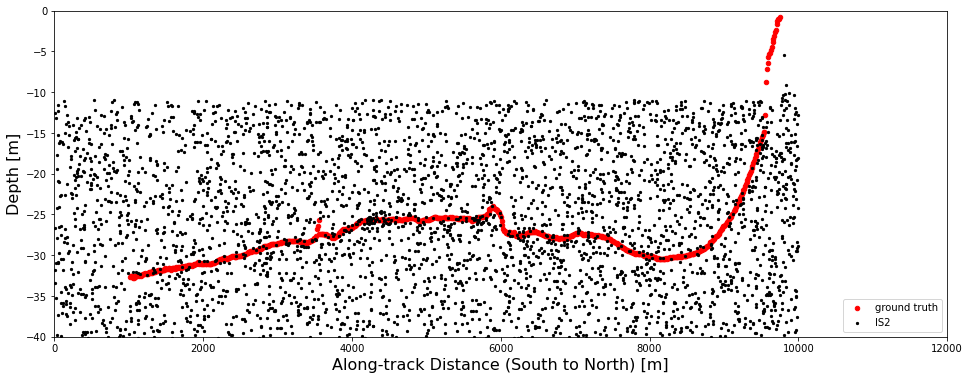

In [12]:
plt.figure(figsize=(16,6))
plt.scatter(alg_gt,z_gt_rel, s = 20, color = 'red', label = 'ground truth')
plt.scatter(np.vstack((a_ns,a_sig)), np.vstack((h_ns,h_sig)), s = 5, color = 'black', label = 'IS2')
#plt.scatter(a_sig,h_sig, s= 5, color = 'black',label = 'signal') 
plt.ylim(-40, 0)
plt.xlim(0, 12000)
plt.xlabel('Along-track Distance (South to North) [m]', fontsize=16)
plt.ylabel('Depth [m]', fontsize=16)
plt.legend(loc='lower right')
#hi = np.vstack((a_ns,a_sig))

In [ ]:
# test different DBSCAN parameters
# test accuracy of DBSCAN method in 10m alongtrack bins
db = 10 #bin size
amin = 3000 #min alongtrack distance
bins = np.arange(start=amin, stop=max(alg), step=db)

ms = np.arange(start=1, stop = 20, step=1) # min_samp values
ev = np.arange(start=0.25, stop = 20, step=.25) #eps_val values
bin_good = np.empty((len(ms),len(ev)))
for m in np.arange(start = 0,stop = len(ms), step = 1):
    min_samp = ms[m]
    
    for e in np.arange(start = 0,stop = len(ev), step = 1):
        eps_val = ev[e] 
        
        print('min_samp')
        print(min_samp)
        print('eps_val')
        print(eps_val)
        
        dbscan = DBSCAN(eps = eps_val, min_samples = min_samp)

        if len(ha) != 0:
            model = dbscan.fit(ha)
            labels = model.labels_
            #signal
            a_sig = algs[labels >= 0]
            h_sig = hs[labels >= 0]
            #noise
            a_ns = algs[labels < 0]
            h_ns = hs[labels < 0]
        else:
            a_sig = np.empty()
            h_sig = np.empty()
            a_ns = np.empty()
            h_ns = np.empty()

        dif = np.empty((len(bins),))
        dif[:] = np.NaN
        for ii in np.arange(start=0,stop=len(bins),step=1):
            gt_in_bin = z_gt_rel[(alg_gt>(bins[ii]-db/2)) & (alg_gt<(bins[ii]+db/2))] # ground truth data in bin
            if gt_in_bin.size>0:
                gtm = np.nanmedian(gt_in_bin) # median value of groud truth in bin
            ib_in_bin = h_sig[(a_sig>(bins[ii]-db/2)) & (a_sig<(bins[ii]+db/2))] # extracted IS2 bathy data in bin
            if ib_in_bin.size>0:
                ibm = np.nanmedian(ib_in_bin) # median value of IS2 bathy in bin
            if ((np.isnan(gtm)==False) & (np.isnan(ibm)==False)):
                dif[ii] = gtm-ibm #difference of median values
        bin_good[m,e] = np.nansum(np.absolute(dif)<5)
        
        

In [ ]:
plt.figure(figsize=(16,6))
ee, mm = np.meshgrid(ev, ms, sparse=False, indexing='xy')
#cnt_param = plt.scatter(mm,ee,s=50,c=bin_good)
cnt_param = plt.contourf(mm, ee, bin_good, levels = 20)#,cmap='jet')#,extend='min')
plt.ylabel('eps_val', fontsize=16)
plt.xlabel('min_samp', fontsize=16)
cbar = plt.colorbar(cnt_param)
#plt.clim(500,696) 
#plt.xlim(2.75, 3.25)
#plt.ylim(4,13)
cbar.set_label('# of segs w/ median height within 5m of GT',fontsize=14)
plt.grid(True)

In [ ]:
print(bin_good)
print(sum(np.absolute(dif)<5))

In [ ]:
# # find median value of ground truth points near each IS2 point
# import scipy.spatial as spatial

# gt_points = np.vstack((xv,yv)).T
# gt_point_tree = spatial.cKDTree(gt_points)
# is_points = np.vstack((df.x.values, df.y.values)).T

# #is this the best way to pre-allocate an array?
# gt_med = np.zeros((len(df.x.values),))

# # bleh = gt_point_tree.query_ball_point(is_points[0], 1)
# # print(bleh)
# # blah = zv[bleh]
# # print(blah)
# # gt_med = np.median(blah)
# # print(gt_med)
# for isp in range(len(is_points)):
#     bleh = gt_point_tree.query_ball_point(is_points[isp], 1)
#     blah = zv[bleh]
#     if len(blah)>0:
#         gt_med[isp] = np.median(blah)

Text(0.5, 1.0, 'US Virgin Islands - Track Intersecting Airport Runway')

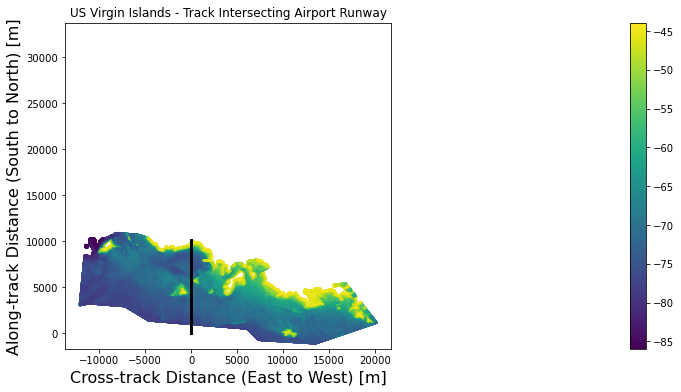

In [16]:
%matplotlib inline
plt.figure(figsize=(16,6))
sct_gt = plt.scatter(crsv,algv, s = 2, c = zv)
cbar = plt.colorbar(sct_gt)
scat_gt = plt.scatter(df.crs,df.alg,s=2, color = 'black')
plt.axis('square')
plt.ylabel('Along-track Distance (South to North) [m]', fontsize=16)
plt.xlabel('Cross-track Distance (East to West) [m]', fontsize=16)
plt.title('US Virgin Islands - Track Intersecting Airport Runway')




In [ ]:
[z1, z2] = zm.shape
print(z1)
print(z2)
print(zm.shape)
blah = range(0, z1)
print(blah[0:10])

print(min(lonv))
print(max(lonv))
print(min(latv))
print(max(latv))

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
print(confo.shape)

In [ ]:
print(alg.shape)

In [ ]:
print()